# Face Generation with DCGAN

In this project, we'll define and train a DCGAN on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible. Our generated samples should look like fairly realistic faces with small amounts of noise.

**Data:**

- [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) The dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

Since the project's main focus is on building the GANs, *some* of the pre-processing is done. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images:

<img src='assets/processed_face_data.png' width=60% />

The preprocessed data (a sub-selection of the original data) can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).

**Notes on project and notebook - improvements:** The code and task in this notebook is quite similar to the previous project (generating housenumbers). But the task is more complex and so we work with a better architecture. And there are several other improvements too, e.g.
- leaner use of nn.Sequential class for definition of NN architecture
- use of odd-sized filters in the conv layers (to counter aliasing errors)
- using batchnorm after the activation filters, practice has changed since the original DCGAN paper
- using a stride of 1 in the last generator layer to avoid checkerboard-like artifacts (more in [this blog post](https://distill.pub/2016/deconv-checkerboard/))
- not implemented: you could train the generator with the same set of fake images that were used for optimizing the discriminator. (There is no need to generate a fresh set of fake images for it's optimization.)

In [1]:
# !unzip processed_celeba_small.zip  # can comment out after executing

In [2]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pickle as pkl
import problem_unittests as tests

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'processed_celeba_small/'

##  Pre-process and Load the Data

**Requirements**:

* Images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Function should return a DataLoader that shuffles and batches these Tensor images.

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """Batch the neural network data using DataLoader.
    
    Arguments:
    ----------
    - batch_size: The size of each batch; the number of images in a batch
    - img_size: The square size of the image data (x, y)
    - data_dir: Directory where image data is located
    
    Returns:
    --------
   - DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         num_workers=num_workers)
    
    return loader

## Create a DataLoader

* Reasonable `batch_size` parameter
* `image_size` **must be** `32`. (Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces.)

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32
num_workers= 0

# Call function
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

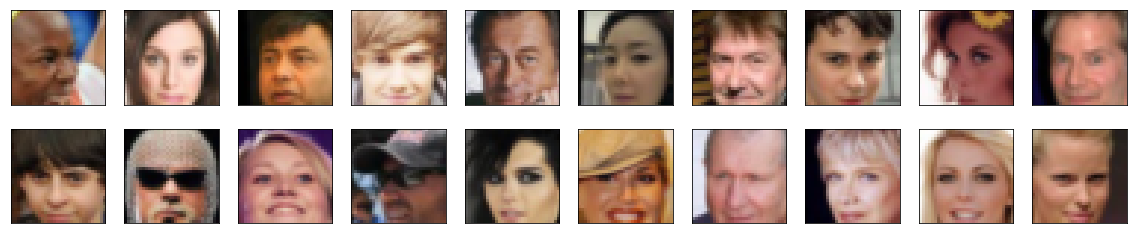

In [5]:
# Define helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

**Pre-processing: scale image data to a pixel range of -1 to 1:** The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    x_min, x_max = feature_range
    x = x * (x_max - x_min) + x_min
    
    return x

In [7]:
# Check scaled range, should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9451)



## Define the Model

### Discriminator

This is like a convolutional classifier, only without any maxpooling layers. 

**Requirements:**
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake
* To deal with this complex data, it's suggested to use a deep network with _normalization_

**Note:** Initially I worked with 4 conv layers but this is not necessary here.

In [8]:
# Define helper function to build conv blocks
def conv(in_channels, out_channels, kernel_size, stride=2, padding=2, 
         batch_norm=True, leaky_relu=True):
    """Creates a convolutional layer, with optional batch normalization."""
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Return using Sequential container
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """ Initialize the Discriminator Module.
        
        Arguments:
        ----------
        - conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        self.conv_blocks = nn.Sequential(
            conv(3, conv_dim, 5, batch_norm=False),  # out: 16 x 16 x 32
            conv(conv_dim, conv_dim * 2, 5),  # out: 8 x 8 x 64
            conv(conv_dim * 2, conv_dim * 4, 5),  # out: 4 x 4 x 128
#             conv(conv_dim * 4, conv_dim * 8, 5),  # out: 2 x 2 x 256 - not used
        )
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """ Forward propagation of the neural network.
        
        Arguments:
        ----------
        - x: The input to the neural network     
        
        Returns:
        --------
        - Discriminator logits; the output of the neural network
        """
        x = self.conv_blocks(x)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)

        return x

In [10]:
# Check
tests.test_discriminator(Discriminator)

Tests Passed


In [11]:
D_test = Discriminator(32)
print(D_test)

Discriminator(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


### Generator

The generator will upsample an input and generate a *new* image of the same size as our training data `32x32x3`, using mostly transpose convolutional layers with normalization applied to the outputs.

**Requirements:**
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

**Note:** Initially I worked with 4 conv layers here (simply mirroring the original encoder), but the results were quite poor. So: Using a simple 4-layer generator which is symmetric to the discriminator is not going to help generate better images. Apart from this, generators which are sufficiently larger than the discriminator in terms of depth, help generate better samples.  So I added two more layers, starting with a bigger dense layer of 7x7x1024.

In [12]:
# Define helper function to build deconv blocks
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=2, 
         batch_norm=True, leaky_relu=True):
    """Creates a transpose convolutional layer, with optional batch norm and
    leake relu activation."""
    
    layers = []
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                    kernel_size, stride, padding, bias=False)
    layers.append(t_conv_layer)
    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    # Return using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """Initialize the Generator Module.
        
        Arguments:
        ----------
        - z_size: The length of the input latent vector, z
        - conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim * 32 * 2 * 2)  
        
        self.t_conv_blocks = nn.Sequential(
            t_conv(conv_dim * 32, conv_dim * 16, 5),
            t_conv(conv_dim * 16, conv_dim * 8, 5),
            t_conv(conv_dim * 8, conv_dim * 4, 5),
            t_conv(conv_dim * 4, conv_dim * 2, 5),
            t_conv(conv_dim * 2, conv_dim, 5),
            # set stride to 1, adapt kernel size accordingly
            t_conv(conv_dim, 3, 4, stride=1, batch_norm=False, leaky_relu=False),
        )
        

    def forward(self, x):
        """ Forward propagation of the neural network.
        
        Arguments:
        ----------
        - x: The input to the neural network     
        
        Returns:
        --------
        - 32x32x3 Tensor image as output
        """
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 32, 2, 2)  # batchsize x 512 x 7 x 7
        x = self.t_conv_blocks(x)
        x = F.tanh(x)
        
        return x

In [14]:
# Check model
tests.test_generator(Generator)

Tests Passed


### Initialize networks weights 

To help the models converge, we initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say: All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

(A more advanced model code can be found in [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py)).

**Requirements:**

* Initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model. The weights are taken 
    from a normal distribution with mean = 0, std dev = 0.02.
    
    Arguments:
    ----------
    - m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
#         m.bias.data.fill_(0)  # bias was set to false

## Build complete network


In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [17]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv_blocks): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(2048, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
     

**Training on GPU**

In [18]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## Define Losses

**Discriminator Losses**

* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


**Generator Loss**

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.


**We may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       
    Arguments:
    ----------
    - D_out: discriminator logits

    Returns:
    --------
    - real loss
    '''
    
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.rand(batch_size) * 0.1 + 0.9 # real labels 0.9 to 1.0
    else:
        labels = torch.ones(batch_size) # real labels = 1   
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       
    Arguments:
    ----------
    - D_out: discriminator logits

    Returns:
    --------
    - fake loss
    '''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [20]:
# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.4
beta2 = 0.999 

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2]) 


## Train model

Training will involve alternating between training the discriminator and the generator and alternating between real and fake images. 

**Saving Samples:** Code is included to print out some loss statistics and save some generated "fake" samples.

In [24]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
 
            if train_on_gpu:
                real_images = real_images.cuda()
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            d_fake_images = D(fake_images)
            g_loss = real_loss(d_fake_images) # use real loss to flip labels
            g_loss.backward()
            g_optimizer.step()            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch_earlier + epoch + 1, epoch_earlier + n_epochs, d_loss.item(), g_loss.item()))
 
        # After each epoch, generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        # After each epoch, save model
        torch.save(D.state_dict(), 'checkpoint_D.pth')
        torch.save(G.state_dict(), 'checkpoint_G.pth')
        print("Model state_dicts saved to disc.")

    # Save training generator samples
    with open('train_samples_2.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [25]:
epoch_earlier = 7  # number of epochs already trained, for print statement only
n_epochs = 1
print_every = 600

# Call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    8/    8] | d_loss: 1.3633 | g_loss: 0.8787
Epoch [    8/    8] | d_loss: 1.4254 | g_loss: 0.8984
Epoch [    8/    8] | d_loss: 1.4105 | g_loss: 0.7921
Epoch [    8/    8] | d_loss: 1.3613 | g_loss: 0.7973
Epoch [    8/    8] | d_loss: 1.3645 | g_loss: 0.7860
Epoch [    8/    8] | d_loss: 1.3491 | g_loss: 0.7756
Epoch [    8/    8] | d_loss: 1.4213 | g_loss: 0.7935
Epoch [    8/    8] | d_loss: 1.3801 | g_loss: 0.8292
Epoch [    8/    8] | d_loss: 1.4033 | g_loss: 0.7475
Epoch [    8/    8] | d_loss: 1.3474 | g_loss: 0.8252
Epoch [    8/    8] | d_loss: 1.3913 | g_loss: 0.8609
Epoch [    8/    8] | d_loss: 1.3507 | g_loss: 0.7982
Epoch [    8/    8] | d_loss: 1.3366 | g_loss: 0.7810
Epoch [    8/    8] | d_loss: 1.3575 | g_loss: 0.7990
Epoch [    8/    8] | d_loss: 1.4269 | g_loss: 0.8505
Epoch [    8/    8] | d_loss: 1.4123 | g_loss: 0.7773
Epoch [    8/    8] | d_loss: 1.3271 | g_loss: 0.8448
Epoch [    8/    8] | d_loss: 1.3348 | g_loss: 0.9079
Epoch [    8/    8] | d_loss

### Save / Re-load models

In [26]:
# Save models
torch.save(D.state_dict(), 'checkpoint_D.pth')
torch.save(G.state_dict(), 'checkpoint_G.pth')

In [22]:
# Reload
D_state_dict = torch.load('checkpoint_D.pth')
G_state_dict = torch.load('checkpoint_G.pth')

D.load_state_dict(D_state_dict)
G.load_state_dict(G_state_dict)

### Plot Training loss

Plot the training losses for the generator and discriminator, recorded after each batch.

Text(0.5,1,'Training Losses')

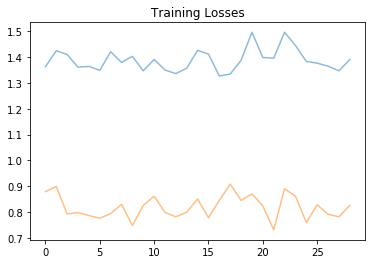

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
# plt.legend()

## Evaluate Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [29]:
# Define helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [30]:
# Load samples from generator, taken while training
with open('train_samples_2.pkl', 'rb') as f:
    samples = pkl.load(f)

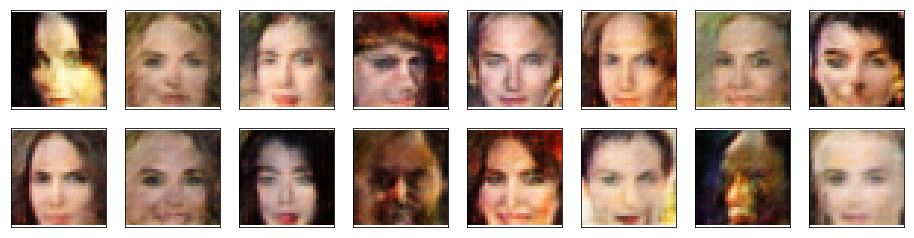

In [39]:
# After 6 Epochs
_ = view_samples(-1, samples)

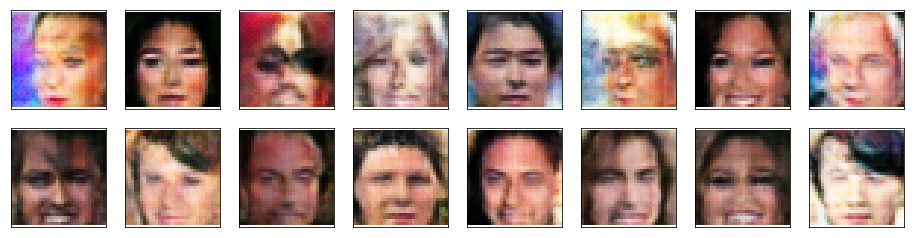

In [45]:
# After 7 Epochs
_ = view_samples(-1, samples)

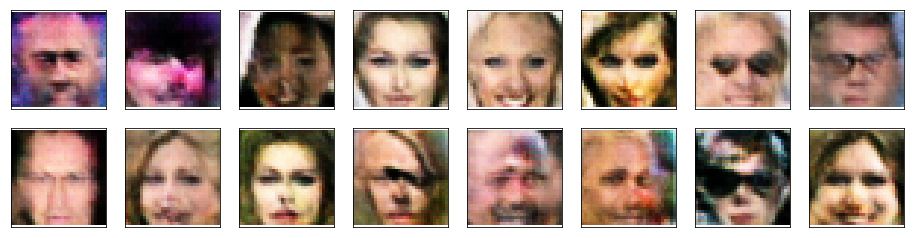

In [31]:
# After 8 Epochs
_ = view_samples(-1, samples)

**Answer:**

* The new architecture seems to work ok, but the training time has increased drastically. In the time I train 2-3 epochs now, I trained about 60 epochs with the former architecture. Interstingly back then I had better results after 20 epochs than in later phases - so the model was hitting a plateau quite fast.
* Would be interesting to see how this model performs after 20, 40, 60 epochs - it might well be that it still improves then, but it just takes too much training time to do it. - But actually the results after the 8th epoch look worse than the earlier ones ...

---